In [1]:
import time
import re, ast
import numpy as np
import os
from IPython.display import clear_output
import findspark
import pandas as pd
findspark.init()
from sklearn import linear_model
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

In [2]:
from pyspark.sql import SparkSession,SQLContext
from pyspark.streaming import StreamingContext
from pyspark.streaming.kafka import KafkaUtils
from pyspark.mllib.regression import StreamingLinearRegressionWithSGD
from pyspark.ml.linalg import Vectors
from pyspark.ml.regression import LinearRegression
os.environ['PYSPARK_SUBMIT_ARGS'] = '--master local[*] pyspark-shell'

spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("MLReceive") \
    .getOrCreate()

In [3]:
#This function creates a connection to a Kafka stream
#You may change the topic, or batch interval
#The Zookeeper server is assumed to be running at 127.0.0.1:2181
#The function returns the Spark context, Spark streaming context, and DStream object
def getKafkaDStream(spark,topic='ml',batch_interval=10):

    #Get Spark context
    sc=spark.sparkContext

    #Create streaming context, with required batch interval
    ssc = StreamingContext(sc, batch_interval)

    #Checkpointing needed for stateful transforms
    ssc.checkpoint("checkpoint")
    
    #Create a DStream that represents streaming data from Kafka, for the required topic 
    dstream = KafkaUtils.createStream(ssc, "zoo1:2181,zoo2:2181,zoo3:2181", "spark-streaming-consumer", {topic: 1})
    
    return [sc,ssc,dstream]

In [4]:
def trainInitialModel():
    global features,sensors
    dfs = []
    for sensor in sensors:
        day1 = pd.read_csv('../../data/2017-02-28_sensor_{0}.csv'.format(sensor),dtype={"measurement": float})
        day1 = day1.dropna()
        dfs.append(day1)
    df = pd.concat(dfs)
    df.sort_values('time', inplace=True)
    dataDict = dict()
    for i in df['sensorid'].unique():
        dataDict[i] = []
    relevantSensors = list(dataDict.keys())
    relevantSensors.remove('1-0')
    ready = False
    i = 0
    rows = df.values.tolist()
    while not ready:
        dataDict[rows[i][2]].append(rows[i][3])
        ready = True
        for s in relevantSensors:
            if len(dataDict[s])<features:
                ready = False
                break
        i+=1

    X_train = []
    Y_train = []
    for s in relevantSensors:
        dataDict[s]  =dataDict[s][-features:]
    if not rows[i-1][2] in relevantSensors:
        x = []
        for s in relevantSensors:
            x.append(dataDict[s])
        X_train.extend(x)
        Y_train.append(rows[i-1][3])
    while i<len(rows):
        if not rows[i][2] in relevantSensors:
            x = []
            for s in relevantSensors:
                x.extend(dataDict[s])
            X_train.append(x)
            Y_train.append(rows[i][3])
        else:
            dataDict[rows[i][2]] = dataDict[rows[i][2]][1:]
            dataDict[rows[i][2]].append(rows[i][3])
        i+=1

    clf = MLPRegressor()
    clf.fit(X_train,Y_train)
    return clf, dataDict,relevantSensors

In [5]:
def predict(data):
    global state1,model1,day,relevantSensors
    start = time.time()
    data = data.collect()
    realValues = []
    predictedValues = []
    newX = []
    newY = []
    i=0
    while i<len(data):
        if not data[i][0] in relevantSensors:
            x = []
            for s in relevantSensors:
                x.extend(dataDict[s])
            newX.append(x)
            newY.append(data[i][1][0])
        else:
            dataDict[data[i][0]] = dataDict[data[i][0]][1:]
            dataDict[data[i][0]].append(data[i][1][0])
        i+=1
    if len(data)>0:
        pred_y = model1.predict(newX)
        print('day',day)
        print('mse :',mean_squared_error(newY,pred_y))
        fig1,ax1 = plt.subplots()
        ax1.plot(pred_y)#,marker='.', alpha=0.5, linestyle='None')
        ax1.plot(newY)#,marker='.', alpha=0.5, linestyle='None')
        plt.title('Temperature for sensor {0} on day {1}'.format(1,day))
        ax1.legend('predicted value','actual value')
        plt.show()
        day+=1

    end = time.time()
    print('time',end-start)

In [ ]:
sc,ssc,dstream = getKafkaDStream(spark)
features = 10
start = time.time()
sensors = [1,2,3,33,35 ]

model1,dataDict,relevantSensors = trainInitialModel()
end = time.time()
print(end-start)
dstream = dstream.map(lambda x: np.array(ast.literal_eval(x[1])))
dstream=dstream.flatMap(lambda x: [(x[1],[float(x[2])])])
day = 2 
dstream.foreachRDD(predict)


0.22387337684631348


time 0.03492879867553711
time 0.010192632675170898
time 0.013708114624023438
day 2
mse : 0.342514117436


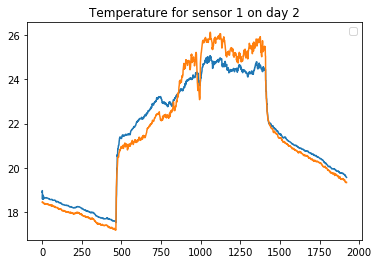

time 0.7384135723114014
day 3
mse : 0.153846325525


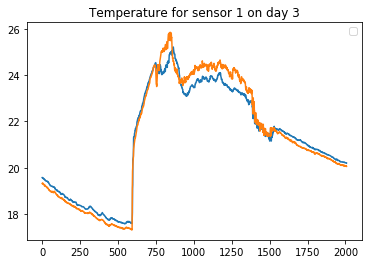

time 0.34154272079467773
day 4
mse : 0.458933122786


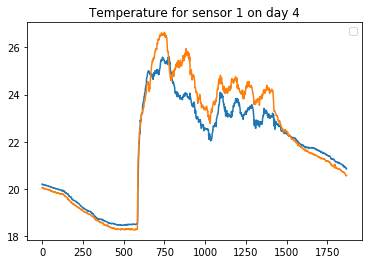

time 0.2672455310821533
day 5
mse : 0.456920630611


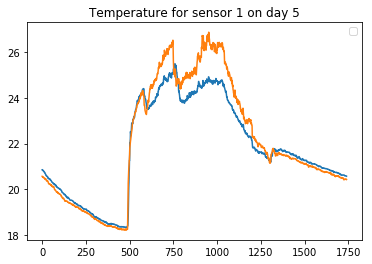

time 0.2918510437011719
day 6
mse : 0.274764372069


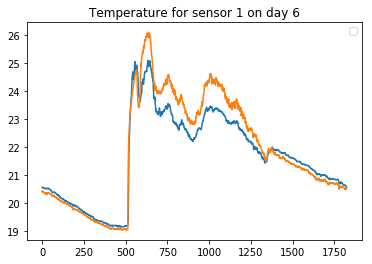

time 0.34139323234558105
day 7
mse : 0.180366128386


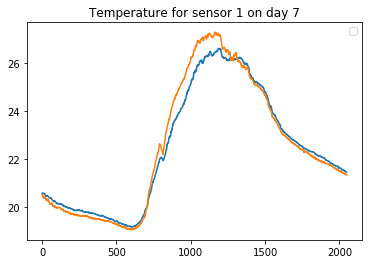

time 0.24355292320251465
day 8
mse : 0.179267354311


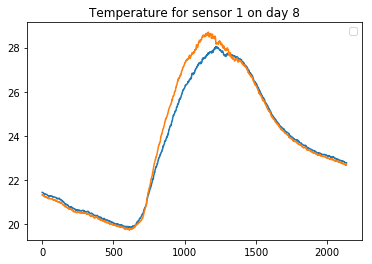

time 0.2644059658050537
time 0.0073506832122802734
time 0.006882667541503906
time 0.007676124572753906
time 0.0070421695709228516
time 0.007207632064819336
time 0.00788736343383789
time 0.007295846939086914
time 0.0071353912353515625
time 0.006669282913208008
time 0.005705356597900391
time 0.00640869140625
time 0.007550477981567383
time 0.010143756866455078
time 0.006676435470581055
time 0.007532596588134766
time 0.005700349807739258
time 0.0066204071044921875
time 0.012420654296875
time 0.006696462631225586
time 0.007933855056762695
time 0.006761789321899414
time 0.006978273391723633
time 0.006827592849731445
time 0.007325172424316406
time 0.006015300750732422
time 0.005585193634033203
time 0.005910396575927734
time 0.005660533905029297
time 0.006254911422729492
time 0.005962371826171875
time 0.005994319915771484
time 0.007033824920654297
time 0.008308649063110352
time 0.007133960723876953
time 0.00719451904296875
time 0.009418249130249023
time 0.006523847579956055
time 0.005026817321

In [ ]:
ssc.start()
ssc.awaitTermination()